In [14]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import CSVLogger
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *

## Create Datasets

In [15]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=32, steps=1)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=32, steps=1)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=32, steps=1)

In [16]:
batch_size = 6
device = 'cuda'
folder_to_save_models = 'weights_32-32'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [17]:
from vunet_conv1d import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=32)

In [18]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard], model_dir=folder_to_save_models, cbs=CSVLogger)

In [19]:
learn.summary()

Net1 (Input shape: 6 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

In [20]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary()

## Training

In [21]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,78.458824,5.026097,0.003575,0.003575,48:53
1,27.290352,0.083811,0.002688,0.002688,51:17


In [22]:
learn.save('Comb_2')

Path('weights_32-32/Comb_2.pth')

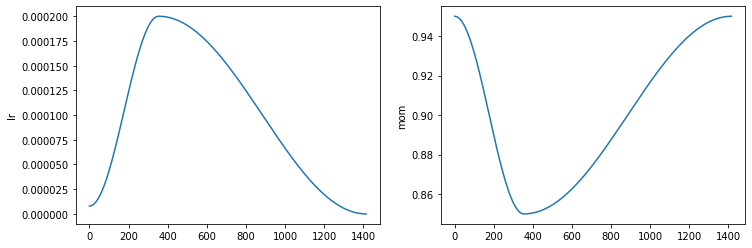

In [23]:
learn.recorder.plot_sched()

In [24]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,1.323593,0.237849,0.002031,0.002031,50:42
1,0.251337,0.004122,0.001958,0.001958,50:30


In [25]:
learn.save('Comb_4')

Path('weights_32-32/Comb_4.pth')

In [26]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.114193,0.044691,0.003339,0.003339,51:13
1,0.037386,0.002437,0.001909,0.001909,45:34


In [27]:
learn.save('Comb_6')

Path('weights_32-32/Comb_6.pth')

In [28]:
learn.fit_flat_cos(2, lr=2e-05, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.041630,0.007250,0.002683,0.002683,49:38
1,0.030455,0.002285,0.001943,0.001943,44:26


In [29]:
learn.save('Comb_8')

Path('weights_32-32/Comb_8.pth')

## Testing

In [30]:
learn.load('Comb_6')

In [31]:
x, y = test_dl.one_batch()
preds = learn.model(x)

In [54]:
pred = preds[0][0].cpu().detach().numpy()
print(pred.shape)

(32, 256, 256)


In [55]:
label = y[0].cpu().detach().numpy()
input = x[0].cpu().detach().numpy()
print(input.shape)

(32, 256, 256)


In [56]:
pred = recover(pred, 17, 32)
label = recover(label, 17, 32)
input = recover(input, 17, 32)

In [57]:
print(pred[:,0,0])
print(label[:,0,0])

[20.03976  21.865953 21.087975 20.785116 22.162014 21.778425 21.61823
 22.628975 21.506874 21.773176 21.579859 20.221035 21.460701 20.54326
 21.456831 21.611746 21.937677 21.0223   20.791319 21.502235 20.582834
 21.654182 21.377491 22.024162 21.458143 21.28527  20.7592   21.907173
 20.720762 22.344639 21.615688 22.019772]
[22.51   22.6175 22.69   22.6375 22.7575 22.7    22.9175 22.6075 22.8475
 22.66   22.87   22.645  22.76   22.915  22.535  22.645  22.49   22.95
 22.6525 22.7275 22.625  22.5325 22.6    22.6525 22.62   22.4825 22.6025
 22.7225 22.995  22.8675 23.02   23.0725]


In [58]:
diff = abs(pred - label)
print(diff[:,0,0])

[2.4702396  0.75154686 1.602026   1.8523846  0.5954857  0.92157555
 1.2992687  0.02147484 1.3406258  0.88682365 1.290142   2.4239655
 1.2992992  2.3717403  1.0781689  1.0332546  0.5523224  1.9277
 1.8611813  1.2252655  2.0421658  0.8783169  1.2225094  0.62833786
 1.1618576  1.1972294  1.8433018  0.8153267  2.2742386  0.5228615
 1.4043121  1.0527287 ]


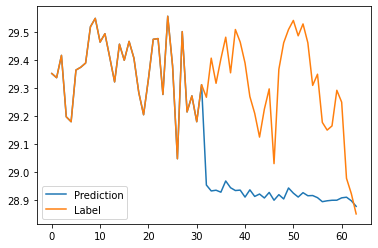

In [61]:
idx = [100, 100]
plt.plot(concat(input[...,idx[0], idx[1]], pred[...,idx[0], idx[1]]))
plt.plot(concat(input[...,idx[0], idx[1]], label[...,idx[0], idx[1]]))
plt.legend(['Prediction', 'Label'])

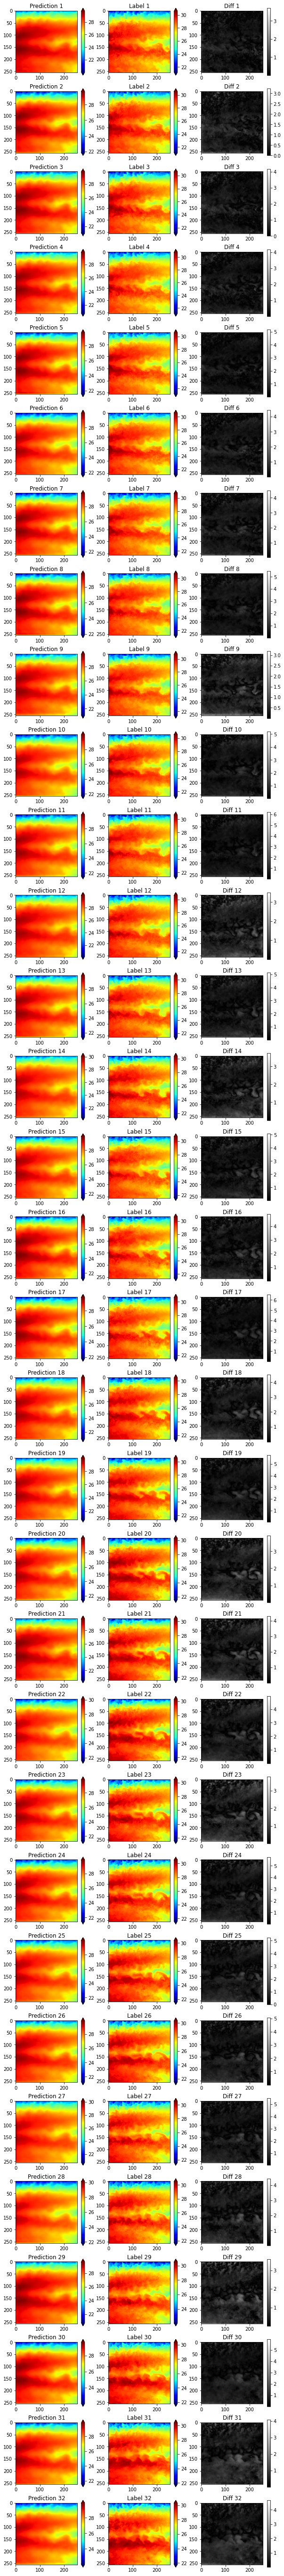

In [60]:
plt.figure(figsize=(10,100))
len = pred.shape[0]
for i in range(len):
    plt.subplot(len, 3, i*3+1)
    plt.imshow(pred[i], cmap='jet')
    plt.title('Prediction {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+2)
    plt.imshow(label[i], cmap='jet')
    plt.title('Label {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+3)
    plt.imshow(diff[i], cmap='gray')
    plt.title('Diff {}'.format(i+1))
    plt.colorbar()
